In [1]:
import pandas as pd
from pandas_datareader import wb
import country_converter as coco
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings

warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

In [3]:
from functions.load import load_target

df = load_target("/content/drive/MyDrive/Colab Notebooks/instquality/files/OECD.csv")

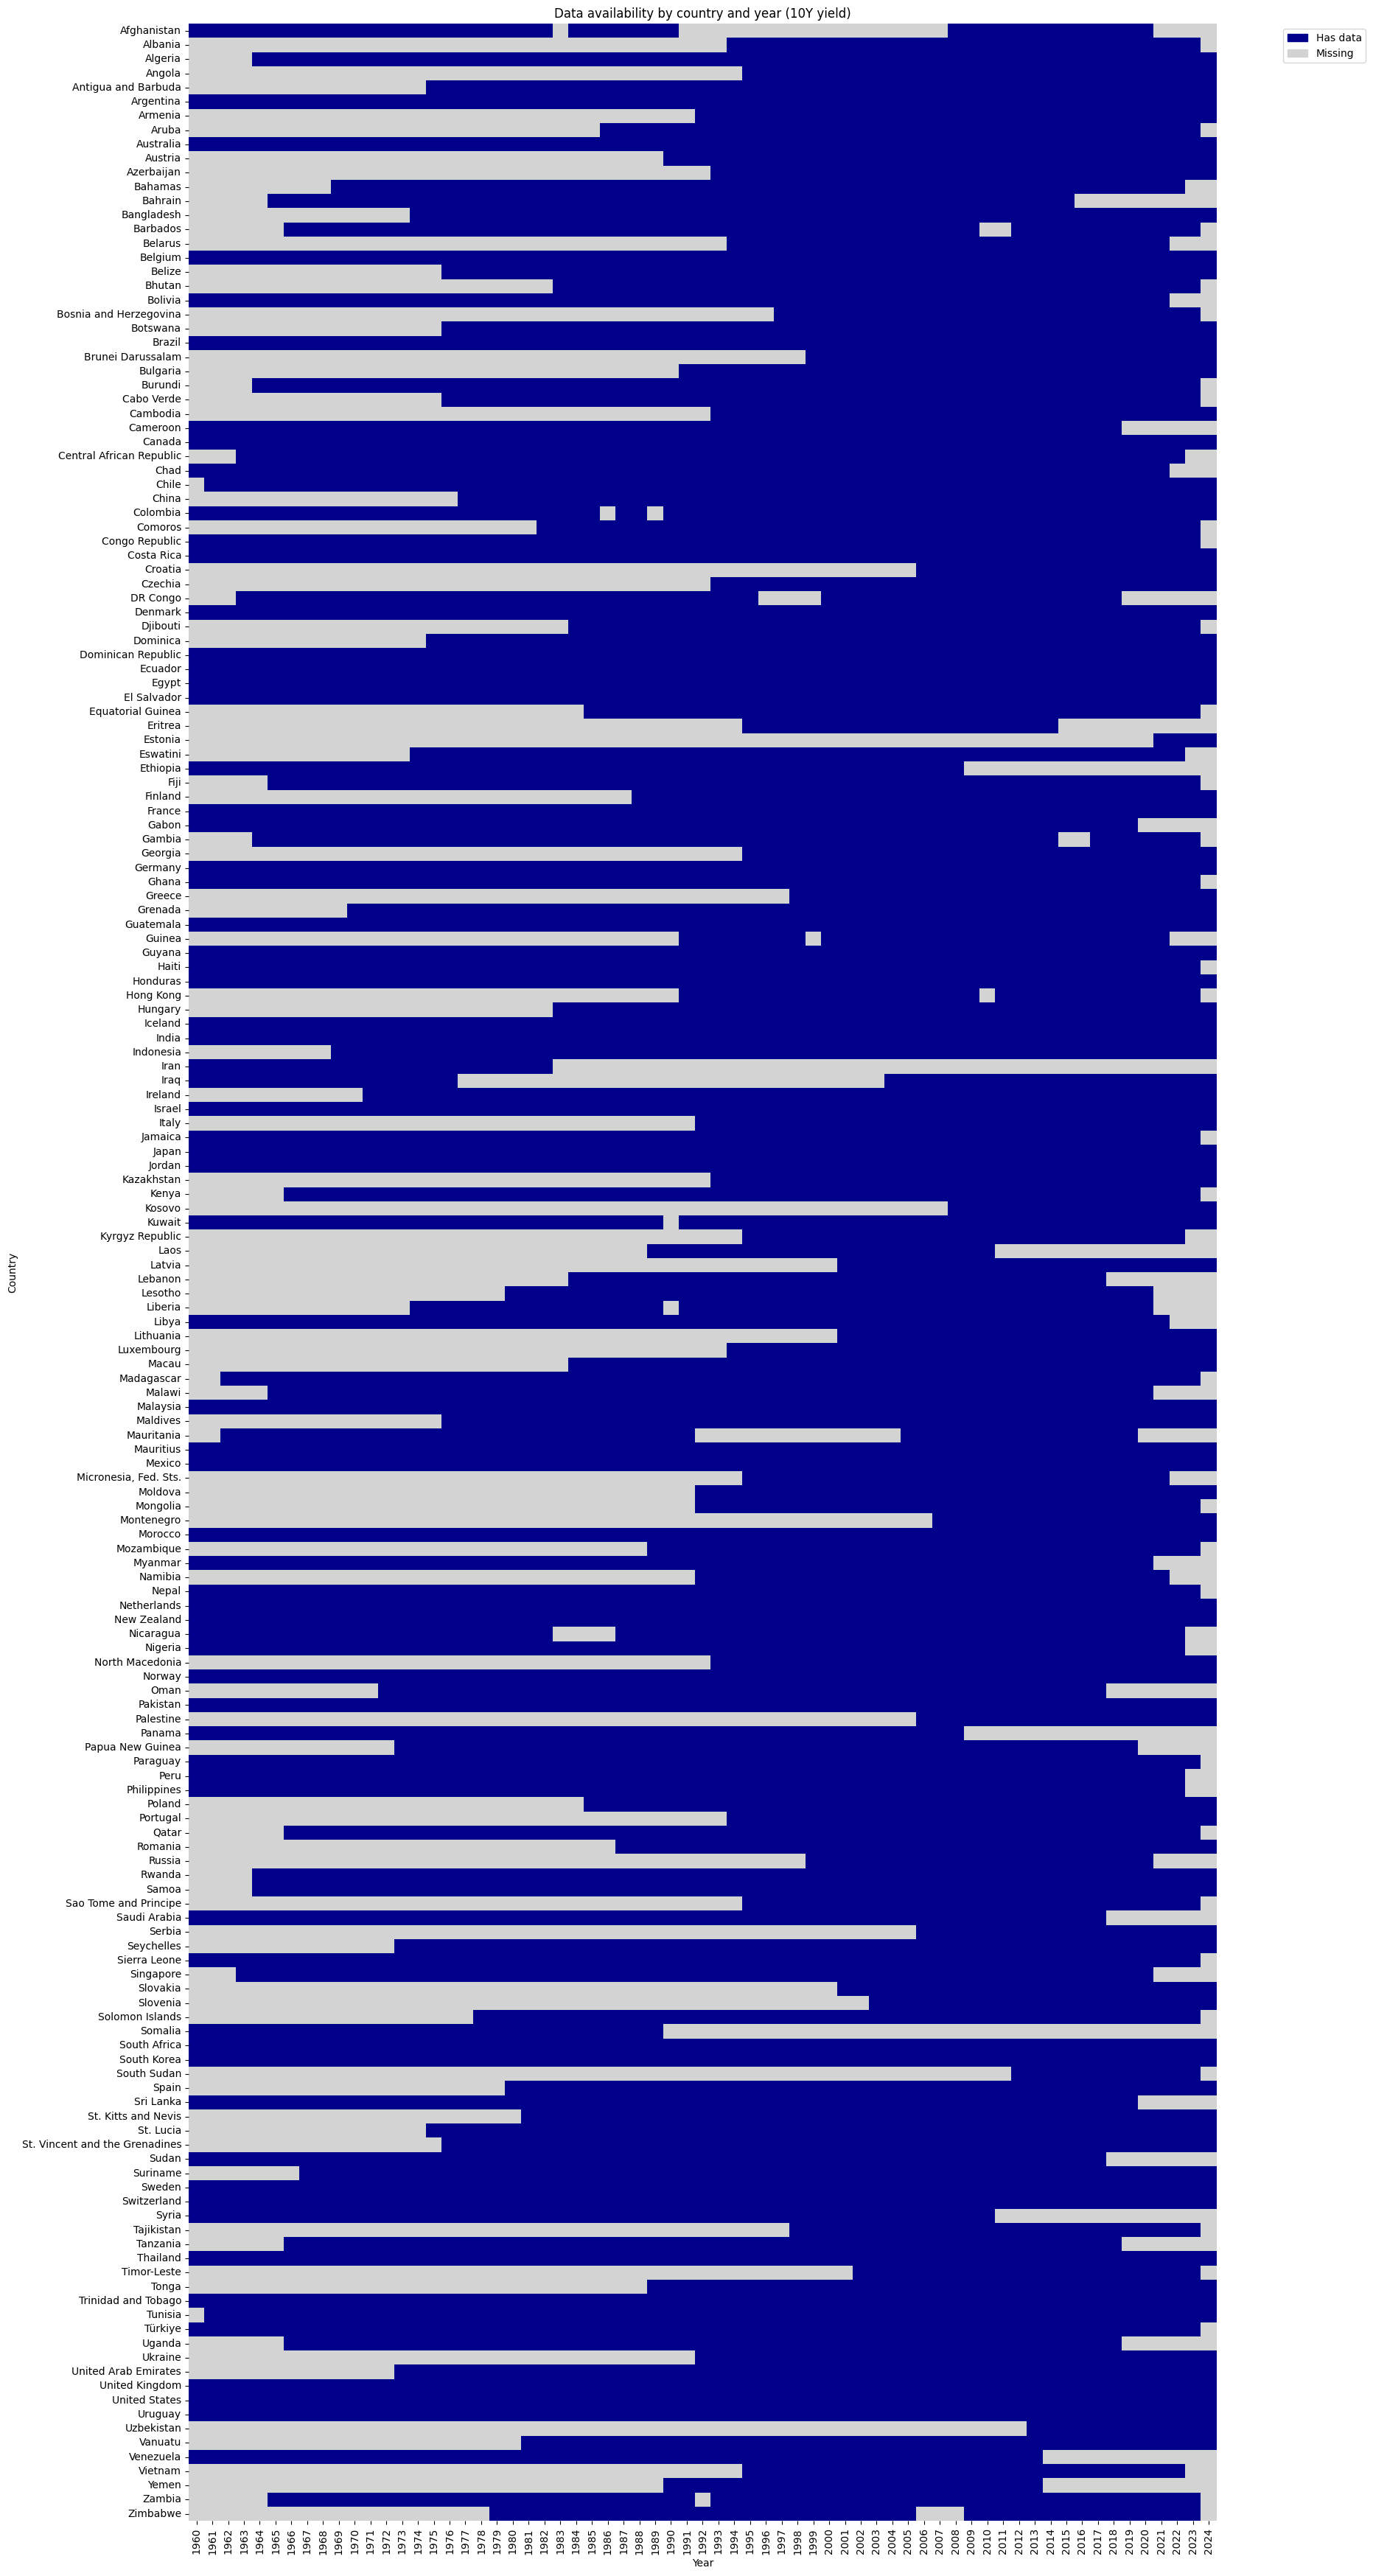

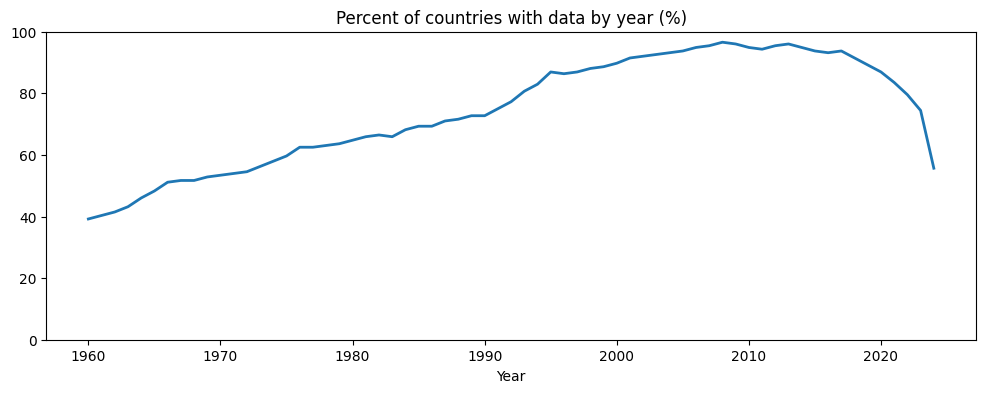

In [5]:
# Clean inputs: make year numeric and within bounds
df2 = df.copy()
df2 = df2[df2.groupby('country')['yield'].transform('count') > 0]
df2['year'] = pd.to_numeric(df2['year'], errors='coerce')
df2 = df2[df2['year'].between(1960, 2024)]

# Build a boolean availability mask via pivot_table (handles duplicates across sources)
# If there are multiple rows per country-year, aggfunc='max' (on the boolean) -> True if ANY source has data
df2['has'] = df2['yield'].notna().astype(int)
mask = df2.pivot_table(index='country', columns='year', values='has',
                       aggfunc='max', fill_value=0).astype(bool)

# Ensure unique, sorted year columns and alphabetical countries
mask.columns = mask.columns.astype(int)
# If some duplicate year labels still sneak in (e.g., after casting), collapse them:
if mask.columns.duplicated().any():
    mask = mask.groupby(mask.columns, axis=1).max()
mask = mask.sort_index(axis=0)  # alphabetical countries
mask = mask.sort_index(axis=1)  # ascending years

# Heatmap of missingness (all countries)
fig, ax = plt.subplots(figsize=(18, max(8, len(mask)/4)))  # auto-scale height
sns.heatmap(mask, cmap=["lightgrey", "darkblue"], cbar=False, ax=ax)
ax.set_title("Data availability by country and year (10Y yield)")
ax.set_xlabel("Year")
ax.set_ylabel("Country")

# Legend
has_data = mpatches.Patch(color="darkblue", label="Has data")
missing  = mpatches.Patch(color="lightgrey", label="Missing")
ax.legend(handles=[has_data, missing], loc="upper right", bbox_to_anchor=(1.15, 1))
plt.show()

# Coverage per year
coverage = mask.sum(axis=0)  # number of countries with data each year
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(coverage.index, coverage.values*100/176, lw=2)
ax.set_title("Percent of countries with data by year (%)")
ax.set_xlabel("Year")
plt.ylim(0,100)
plt.show()